In [2]:
import yfinance as yf

tickers = ['SPY', 'QQQ', 'TLT', 'GLD']
data = yf.download(tickers, start="2018-01-01", end="2023-01-01", auto_adjust=True)['Close']
data.to_csv('etf_data.csv')


[*********************100%***********************]  4 of 4 completed


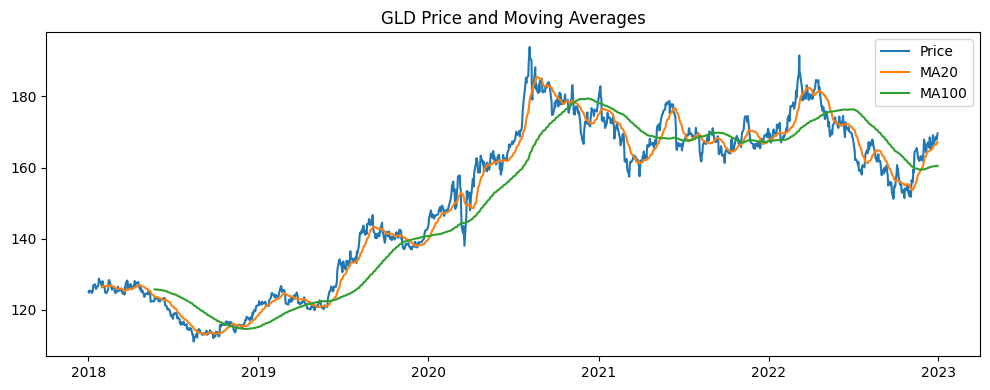

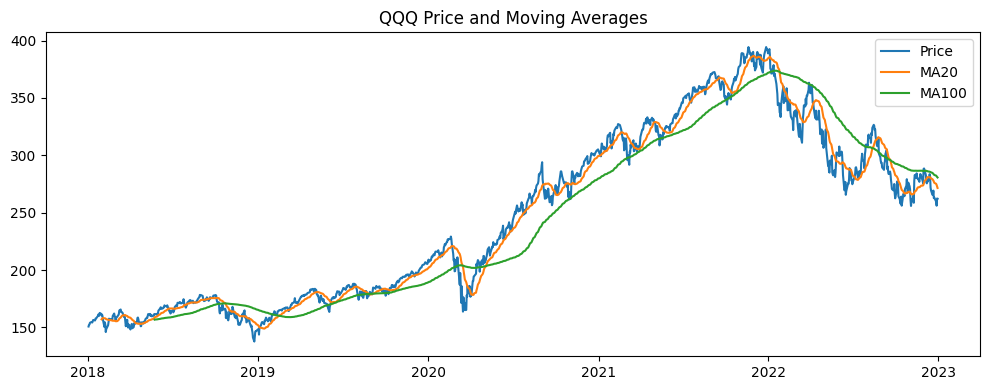

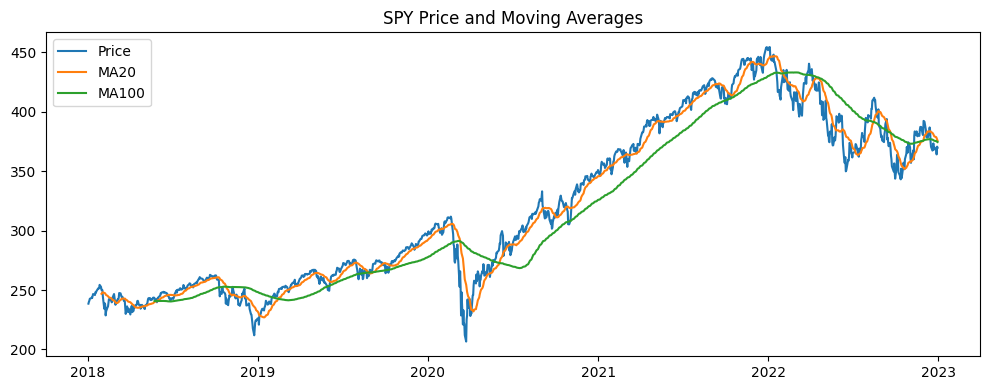

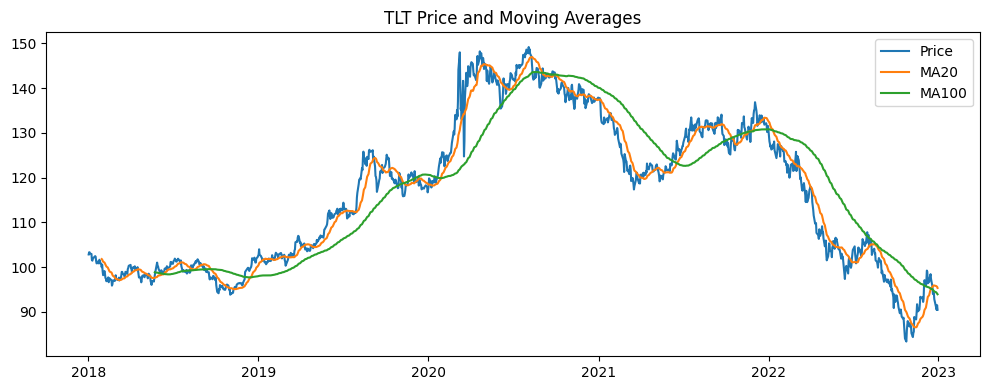

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv('etf_data.csv', index_col=0, parse_dates=True)


signals = {}


for etf in data.columns:
    df = pd.DataFrame(index=data.index)
    df['Price'] = data[etf]
    

    df['MA20'] = df['Price'].rolling(window=20).mean()
    df['MA100'] = df['Price'].rolling(window=100).mean()
    df['Momentum20'] = df['Price'].pct_change(periods=20)
    df['Volatility20'] = df['Price'].rolling(window=20).std()
    

    df['Signal'] = 0
    df.loc[df['MA20'] > df['MA100'], 'Signal'] = 1
    df.loc[df['MA20'] < df['MA100'], 'Signal'] = -1
    
    signals[etf] = df

    plt.figure(figsize=(10, 4))
    plt.plot(df['Price'], label='Price')
    plt.plot(df['MA20'], label='MA20')
    plt.plot(df['MA100'], label='MA100')
    plt.title(f'{etf} Price and Moving Averages')
    plt.legend()
    plt.tight_layout()
    plt.show()


<Axes: title={'center': 'Smart ETF Strategy Equity Curve'}, xlabel='Date'>

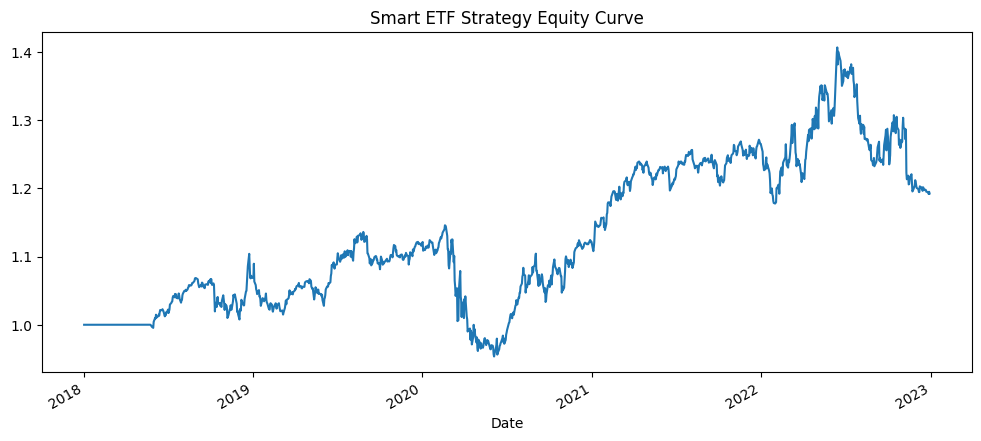

In [ ]:
import numpy as np


signal_df = pd.DataFrame({etf: signals[etf]['Signal'] for etf in signals})
price_df = pd.DataFrame({etf: signals[etf]['Price'] for etf in signals})


daily_returns = price_df.pct_change()


strategy_returns = (signal_df.shift(1) * daily_returns) / len(signals)


equity_curve = (1 + strategy_returns.sum(axis=1)).cumprod()


equity_curve.plot(figsize=(12, 5), title="Smart ETF Strategy Equity Curve")


In [6]:
def sharpe_ratio(returns, rf=0.0):
    excess = returns - rf / 252
    return np.sqrt(252) * excess.mean() / excess.std()

def max_drawdown(equity_curve):
    peak = equity_curve.cummax()
    drawdown = (equity_curve - peak) / peak
    return drawdown.min()

total_return = equity_curve[-1] - 1
cagr = (equity_curve[-1])**(252 / len(equity_curve)) - 1
sharpe = sharpe_ratio(strategy_returns.sum(axis=1))
mdd = max_drawdown(equity_curve)

print(f"CAGR: {cagr:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {mdd:.2%}")


CAGR: 3.59%
Sharpe Ratio: 0.36
Max Drawdown: -16.79%


C:\Users\Abhi\AppData\Local\Temp\ipykernel_14456\1673796717.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = equity_curve[-1] - 1
C:\Users\Abhi\AppData\Local\Temp\ipykernel_14456\1673796717.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = (equity_curve[-1])**(252 / len(equity_curve)) - 1


<Axes: title={'center': 'Volatility-Parity Weighted Equity Curve'}, xlabel='Date'>

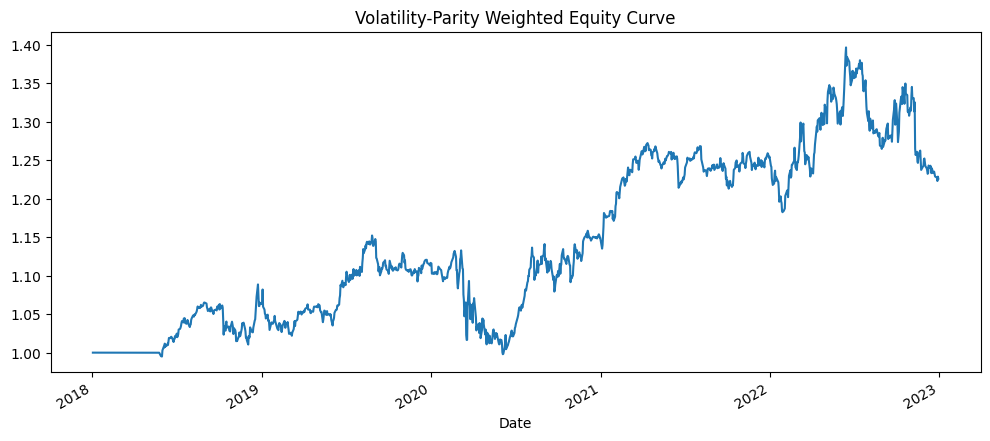

In [ ]:
from numpy.linalg import inv


cov = daily_returns.cov()


inv_vol = 1 / daily_returns.std()
weights = inv_vol / inv_vol.sum()


weighted_returns = (signal_df.shift(1) * daily_returns).mul(weights, axis=1)
weighted_equity_curve = (1 + weighted_returns.sum(axis=1)).cumprod()

weighted_equity_curve.plot(figsize=(12, 5), title="Volatility-Parity Weighted Equity Curve")


In [ ]:

latest_data = yf.download(tickers, period="30d", interval="1d", auto_adjust=True)['Close']



[*********************100%***********************]  4 of 4 completed


In [ ]:
latest_data.to_csv("latest_etf_data.csv")

latest_data.to_pickle("latest_etf_data.pkl")